In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import joblib

In [2]:
# Detect Google Colab environment
running_in_colab = "COLAB_GPU" in os.environ

if running_in_colab:
    # In Colab, assume user uploaded a folder named data
    BASE = Path("/content/data")
    if not BASE.exists():
        BASE = Path("/content")
else:
    # Local environment logic
    current_dir = Path.cwd()

    # If notebook is inside /notebooks/, data is one level up
    if (current_dir.parent / "data").exists():
        BASE = current_dir.parent / "data"
    # If notebook and data are in the same folder
    elif (current_dir / "data").exists():
        BASE = current_dir / "data"
    else:
        BASE = current_dir
        print("Warning: Could not find a 'data' folder. Looking in current directory.")

print("Using BASE directory:", BASE)

# Load training files (no /content/ prefix)
benef = pd.read_csv(BASE / "Train_Beneficiarydata-1542865627584.csv")
inp   = pd.read_csv(BASE / "Train_Inpatientdata-1542865627584.csv", on_bad_lines='skip', engine='python')
outp  = pd.read_csv(BASE / "Train_Outpatientdata-1542865627584.csv", on_bad_lines='skip', engine='python')
labels = pd.read_csv(BASE / "Train-1542865627584.csv")

print("Data loaded successfully.")


Using BASE directory: D:\fraud_detection_project\data
Data loaded successfully.


In [3]:
# Inpatient date columns
date_cols_inp = ["ClaimStartDt", "ClaimEndDt", "AdmissionDt", "DischargeDt"]
for col in date_cols_inp:
    inp[col] = pd.to_datetime(inp[col], errors="coerce")

# Outpatient date columns
date_cols_out = ["ClaimStartDt", "ClaimEndDt"]
for col in date_cols_out:
    outp[col] = pd.to_datetime(outp[col], errors="coerce")

# Beneficiary DOB & DOD
benef["DOB"] = pd.to_datetime(benef["DOB"], errors="coerce")
benef["DOD"] = pd.to_datetime(benef["DOD"], errors="coerce")

print("Dates parsed successfully.")

Dates parsed successfully.


In [4]:
benef["Age"] = (pd.Timestamp("2017-12-31") - benef["DOB"]).dt.days // 365
benef["Age"] = benef["Age"].clip(lower=0)

print("Age feature created.")

Age feature created.


In [5]:
# Add beneficiary demographics & chronic conditions into inpatient claims
inp_merged = inp.merge(benef, on="BeneID", how="left")

# Outpatient claims with beneficiary info
outp_merged = outp.merge(benef, on="BeneID", how="left")

print("Beneficiary data merged into claims.")

Beneficiary data merged into claims.


In [6]:
# Updated Cell 6: Include State for Geographic Analysis
# We take the mode (most common) State for the provider's patients
benef_features = inp_merged.groupby("Provider").agg(
    num_unique_patients=("BeneID", "nunique"),
    avg_age=("Age", "mean"),
    pct_male=("Gender", lambda x: (x == 1).mean()),
    pct_female=("Gender", lambda x: (x == 2).mean()),
    pct_deceased=("DOD", lambda x: x.notna().mean()),
    common_state=("State", lambda x: x.mode()[0] if not x.mode().empty else np.nan) # Added for Geographic EDA
).reset_index()

print("Beneficiary → provider aggregation completed (with State).")

Beneficiary → provider aggregation completed (with State).


In [7]:
# Length of stay
inp_merged["LengthOfStay"] = (inp_merged["ClaimEndDt"] - inp_merged["ClaimStartDt"]).dt.days

inp_features = inp_merged.groupby("Provider").agg(
    num_inpatient_claims=("ClaimID", "count"),
    inpatient_unique_patients=("BeneID", "nunique"),
    avg_inpatient_payment=("InscClaimAmtReimbursed", "mean"),
    total_inpatient_payment=("InscClaimAmtReimbursed", "sum"),
    max_inpatient_payment=("InscClaimAmtReimbursed", "max"),
    avg_length_of_stay=("LengthOfStay", "mean"),
    max_length_of_stay=("LengthOfStay", "max"),
    avg_inpatient_deductible=("DeductibleAmtPaid", "mean")
).reset_index()

print("Inpatient aggregation completed.")

Inpatient aggregation completed.


In [8]:
# Claim duration
outp_merged["ClaimDuration"] = (outp_merged["ClaimEndDt"] - outp_merged["ClaimStartDt"]).dt.days

outp_features = outp_merged.groupby("Provider").agg(
    num_outpatient_claims=("ClaimID", "count"),
    outpatient_unique_patients=("BeneID", "nunique"),
    avg_outpatient_payment=("InscClaimAmtReimbursed", "mean"),
    total_outpatient_payment=("InscClaimAmtReimbursed", "sum"),
    max_outpatient_payment=("InscClaimAmtReimbursed", "max"),
    avg_claim_duration=("ClaimDuration", "mean"),
    avg_outpatient_deductible=("DeductibleAmtPaid", "mean")
).reset_index()

print("Outpatient aggregation completed.")

Outpatient aggregation completed.


In [9]:
provider_df = labels.copy()

provider_df = provider_df.merge(benef_features, on="Provider", how="left")
provider_df = provider_df.merge(inp_features, on="Provider", how="left")
provider_df = provider_df.merge(outp_features, on="Provider", how="left")

# Save inside the BASE directory (works for Colab + local)
output_path = BASE / "provider_level_dataset.csv"
provider_df.to_csv(output_path, index=False)

print("Saved provider_level_dataset.csv successfully at:", output_path)
print("Final provider-level dataset created.")

Saved provider_level_dataset.csv successfully at: D:\fraud_detection_project\data\provider_level_dataset.csv
Final provider-level dataset created.


In [10]:
provider_df.head()

,Provider,PotentialFraud,num_unique_patients,avg_age,pct_male,pct_female,pct_deceased,common_state,num_inpatient_claims,inpatient_unique_patients,...,avg_length_of_stay,max_length_of_stay,avg_inpatient_deductible,num_outpatient_claims,outpatient_unique_patients,avg_outpatient_payment,total_outpatient_payment,max_outpatient_payment,avg_claim_duration,avg_outpatient_deductible
0,PRV51001,No,5.0,86.200000,0.400000,0.600000,0.000000,1.0,5.0,5.0,...,5.000000,14.0,1068.0,20.0,19.0,382.000000,7640.0,1500.0,0.550000,0.000000
1,PRV51003,Yes,53.0,78.483871,0.338710,0.661290,0.016129,1.0,62.0,53.0,...,5.161290,27.0,1068.0,70.0,66.0,466.714286,32670.0,3300.0,2.357143,1.000000
2,PRV51004,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,149.0,138.0,350.134228,52170.0,3300.0,1.429530,2.080537
3,PRV51005,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1165.0,495.0,241.124464,280910.0,4080.0,1.088412,3.175966
4,PRV51007,No,3.0,86.333333,0.333333,0.666667,0.000000,1.0,3.0,3.0,...,5.333333,7.0,1068.0,69.0,56.0,213.188406,14710.0,3300.0,0.768116,0.869565


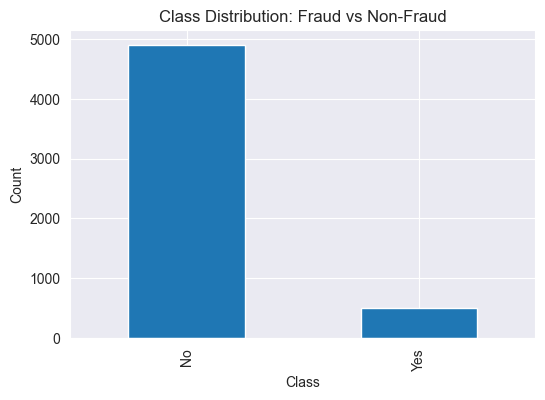

In [11]:

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
labels['PotentialFraud'].value_counts().plot(kind='bar')
plt.title("Class Distribution: Fraud vs Non-Fraud")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

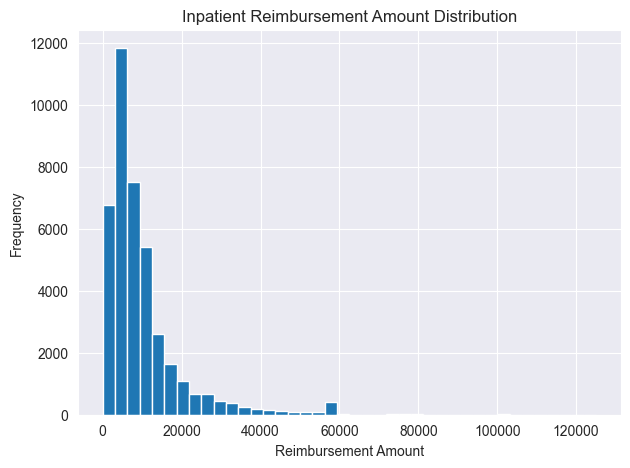

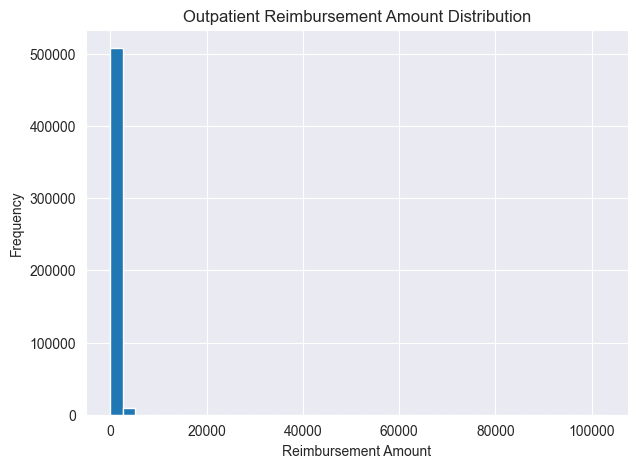

In [12]:
# Inpatient
plt.figure(figsize=(7,5))
inp["InscClaimAmtReimbursed"].hist(bins=40)
plt.title("Inpatient Reimbursement Amount Distribution")
plt.xlabel("Reimbursement Amount")
plt.ylabel("Frequency")
plt.show()

# Outpatient
plt.figure(figsize=(7,5))
outp["InscClaimAmtReimbursed"].hist(bins=40)
plt.title("Outpatient Reimbursement Amount Distribution")
plt.xlabel("Reimbursement Amount")
plt.ylabel("Frequency")
plt.show()


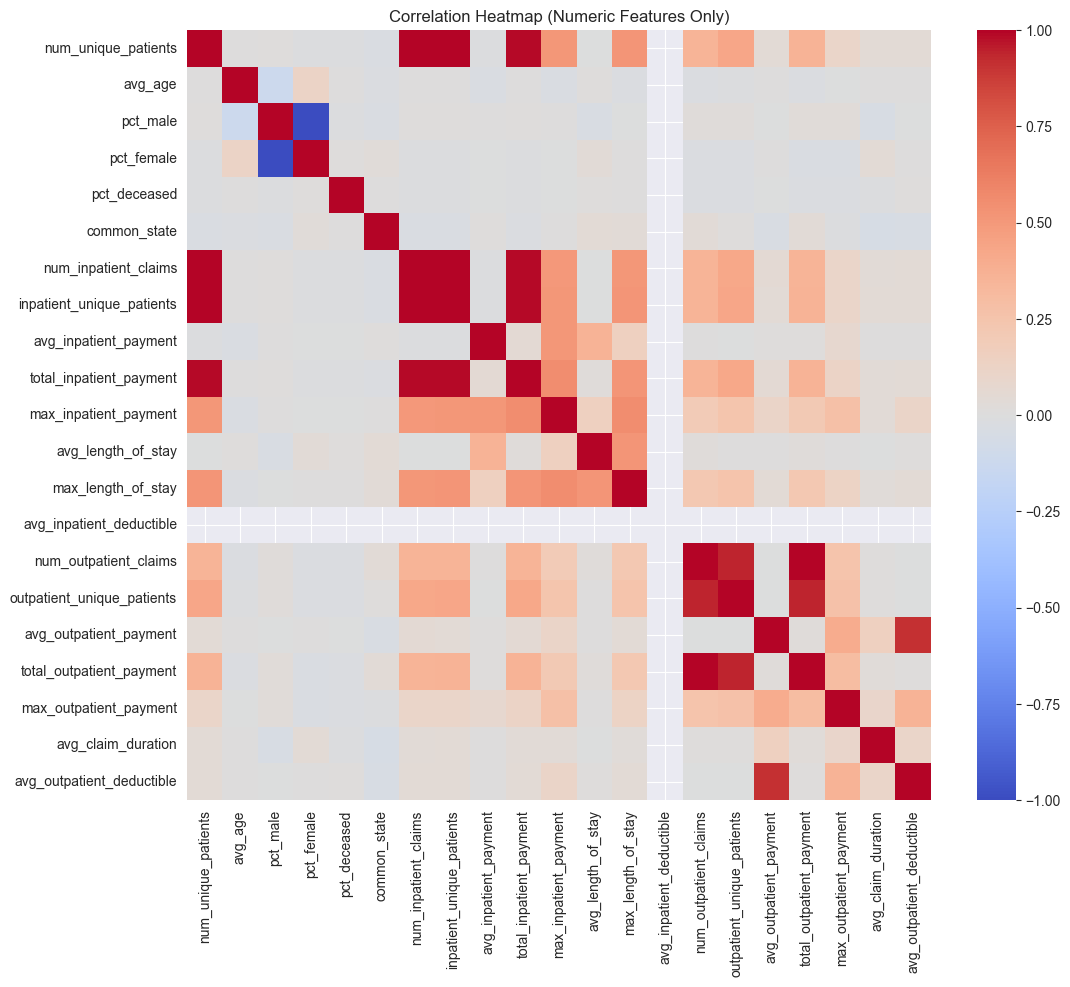

In [13]:
import seaborn as sns
plt.figure(figsize=(12,10))

numeric_cols = provider_df.select_dtypes(include=np.number)

corr_matrix = numeric_cols.corr()

sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

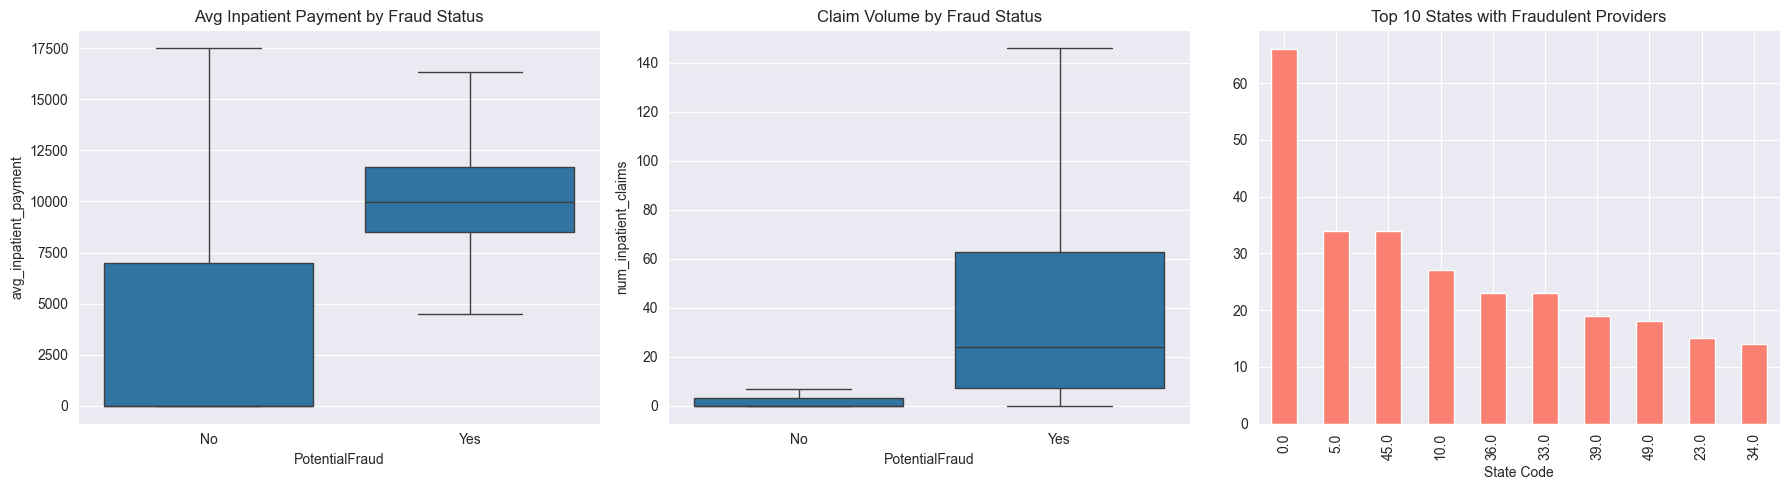

In [14]:
import seaborn as sns

# Fix NaNs before plotting (Providers with no inpatient claims get 0)
provider_df.fillna(0, inplace=True)

# Requirement: Visual comparison of Fraud vs Legitimate
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Average Inpatient Payment
sns.boxplot(x='PotentialFraud', y='avg_inpatient_payment', data=provider_df, ax=axes[0], showfliers=False)
axes[0].set_title("Avg Inpatient Payment by Fraud Status")

# Plot 2: Number of Claims
sns.boxplot(x='PotentialFraud', y='num_inpatient_claims', data=provider_df, ax=axes[1], showfliers=False)
axes[1].set_title("Claim Volume by Fraud Status")

# Plot 3: Geographic Pattern (Top 10 States with Fraud)
fraud_by_state = provider_df[provider_df['PotentialFraud'] == 'Yes']['common_state'].value_counts().head(10)
fraud_by_state.plot(kind='bar', ax=axes[2], color='salmon')
axes[2].set_title("Top 10 States with Fraudulent Providers")
axes[2].set_xlabel("State Code")

plt.tight_layout()
plt.show()

In [15]:
# Cell 14: Final Feature Engineering & Saving

# 1. Binary Encoding for Target (Yes=1, No=0)
provider_df['PotentialFraud'] = provider_df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# 2. State Encoding (Frequency Encoding)
state_counts = provider_df['common_state'].value_counts()
provider_df['state_freq'] = provider_df['common_state'].map(state_counts)

# 3. Drop non-numeric columns
# CRITICAL FIX: We must drop 'Provider' (ID) and 'common_state' (Text)
final_df = provider_df.drop(['common_state', 'Provider'], axis=1)

# 4. Save processed data for Notebook 02
output_file = BASE / "processed_data_ready_for_modeling.csv"
final_df.to_csv(output_file, index=False)

print(f"Feature Engineering Complete. Processed data saved to: {output_file}")
print("Ready for Notebook 02.")

Feature Engineering Complete. Processed data saved to: D:\fraud_detection_project\data\processed_data_ready_for_modeling.csv
Ready for Notebook 02.


In [16]:

print("Shape:", provider_df.shape)
provider_df.describe().T

Shape: (5410, 24)


,count,mean,std,min,25%,50%,75%,max
PotentialFraud,5410.0,0.093530,0.291201,0.0,0.000000,0.000000,0.000000,1.0
num_unique_patients,5410.0,6.768207,20.906996,0.0,0.000000,0.000000,5.000000,458.0
avg_age,5410.0,31.582600,40.011489,0.0,0.000000,0.000000,80.103338,108.0
pct_male,5410.0,0.163013,0.258685,0.0,0.000000,0.000000,0.333333,1.0
pct_female,5410.0,0.223678,0.322693,0.0,0.000000,0.000000,0.500000,1.0
pct_deceased,5410.0,0.003393,0.032547,0.0,0.000000,0.000000,0.000000,1.0
common_state,5410.0,9.964880,15.902918,0.0,0.000000,0.000000,17.000000,54.0
num_inpatient_claims,5410.0,7.481331,23.704217,0.0,0.000000,0.000000,5.000000,516.0
inpatient_unique_patients,5410.0,6.768207,20.906996,0.0,0.000000,0.000000,5.000000,458.0
avg_inpatient_payment,5410.0,3947.382878,5909.941519,0.0,0.000000,0.000000,8333.333333,57000.0
